In [8]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# 클래스 - encoding 변환 함수
def get_convert(class_dir='./open/classes.txt'):
    f = open(class_dir, 'r')
    lines = [list(line.strip().split(',')) for line in f.readlines()]
    f.close()

    encode = {}
    decode = {}
    for cls_num, cls_name in lines:
        encode[int(cls_num)] = cls_name
        decode[cls_name] = int(cls_num)
    
    return encode, decode

# 클래스 - 색상 변환
palette = [(220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
         (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
         (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42), 
         (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157), 
         (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
         (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176), (255, 99, 164),
         (92, 0, 73), (133, 129, 255), (78, 180, 255), (0, 228, 0)]

encode, decode = get_convert()

In [9]:
# csv 불러오기
base_dir = './results/valid_conf25_iou7_angnms.csv'
df = pd.read_csv(base_dir)

# 이미지별 bbox 정보 저장
results_dict = defaultdict(list)
for i in range(len(df)):
    info = dict(df.iloc[i])
    results_dict[info['file_name']].append(info)

df

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y
0,syn_01302.png,8,0.986470,378,395,633,395,633,670,378,670
1,syn_01302.png,10,0.976345,687,220,950,220,950,474,687,474
2,syn_01302.png,10,0.971451,1110,332,1411,332,1411,606,1110,606
3,syn_01302.png,8,0.986470,378,395,633,395,633,670,378,670
4,syn_01302.png,10,0.976345,687,220,950,220,950,474,687,474
...,...,...,...,...,...,...,...,...,...,...,...
4115,syn_04424.png,16,0.440127,412,472,648,472,648,734,412,734
4116,syn_04424.png,6,0.986991,648,215,922,215,922,469,648,469
4117,syn_04424.png,14,0.932380,1124,390,1424,390,1424,676,1124,676
4118,syn_04424.png,28,0.698585,365,472,643,472,643,803,365,803


In [43]:
# 이미지와 bbox 확인
def vis_by_name(image_name='152410640.png', base_dir='./open/train', axis='on', valid=False):

    image_path = os.path.join(base_dir, image_name)

    ### 예측 시각화
    image = cv2.imread(image_path)
    if valid:
        fig, axes = plt.subplots(2,1, figsize=(20, 10))
    else:
        fig, axes = plt.subplots(1, figsize=(20, 10))

    # bbox 정보 불러오기
    anno_lines = results_dict[image_name]
    for line in anno_lines:
        cls = encode[line['class_id']]
        title = f"{cls} \n {line['confidence']}"
        x1, y1 = line['point1_x'], line['point1_y']
        x2, y2 = line['point2_x'], line['point2_y']
        x3, y3 = line['point3_x'], line['point3_y']
        x4, y4 = line['point4_x'], line['point4_y']

        pts = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], np.int32)

        # bbox 표시
        image = cv2.polylines(image, [pts], True, palette[line['class_id']], 3)
        
        # 클래스명 표시
        cv2.putText(
            image,
            text=title,
            org=(pts[0][0]+2,pts[0][1]-5), 
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=1,
            color=palette[line['class_id']], 
            thickness=2,
            lineType=cv2.LINE_AA,
        )
        print(cls)
        


    if valid:
        axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[0].axis(axis)
    else:
        axes.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes.axis(axis)

    if valid:
        ### 정답 시각화
        name, ext = image_name.split('.')
        anno_path = os.path.join(base_dir, name+'.txt')
        image = cv2.imread(image_path)

        anno_file = open(anno_path, 'r')
        anno_lines = [list(map(float, line.strip().split())) for line in anno_file.readlines()]
        anno_file.close()
        for line in anno_lines:
            cls, x1, y1, x2, y2, x3, y3, x4, y4 = map(int, line)
            pts = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], np.int32)

            # bbox 표시
            image = cv2.polylines(image, [pts], True, palette[cls], 3)
            
            # 클래스명 표시
            cv2.putText(
                image,
                text=encode[cls],
                org=(pts[0][0]+2,pts[0][1]-5), 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=1,
                color=palette[cls], 
                thickness=2,
                lineType=cv2.LINE_AA,
            )

        axes[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[1].axis(axis)


def vis_by_idx(image_idx=0, base_dir='./open/train', axis='on', valid=False):
    image_names = list(results_dict.keys())
    image_name = image_names[image_idx]
    print(image_name)
    vis_by_name(image_name=image_name, base_dir=base_dir, axis=axis, valid=valid)


[ WARN:0@1448.361] global loadsave.cpp:244 findDecoder imread_('./open/train/152410640.png'): can't open/read file: check file path/integrity


error: OpenCV(4.7.0) /Users/xperience/GHA-OCV-Python/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


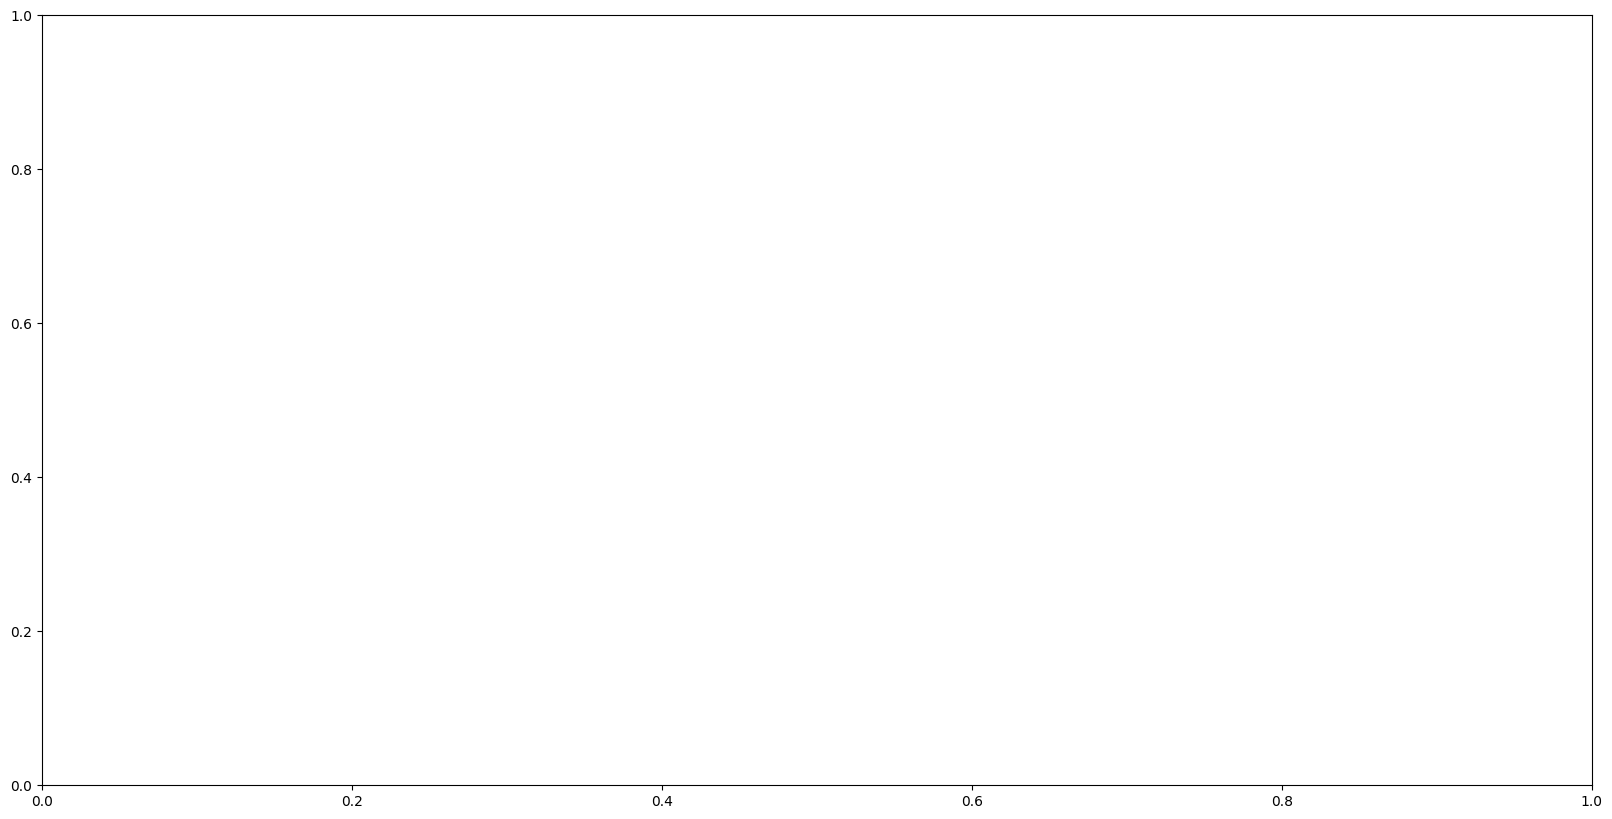

In [48]:
#vis_by_idx(image_idx=2)
vis_by_name(image_name='152410640.png')